## Automated Keyword Extraction from Articles using Natural Language Processing
- Data source: Kaggle public datasets 
- Dataset name: NIPS Papers (Titles, authors, abstracts, and extracted text for all NIPS papers (1987-2017))
- Link: kaggle.com/benhamner/nips-papers#papers.csv

# Load data and python libraries

In [1]:
%matplotlib inline 

# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd 

# data visualisation libraries
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud

#supporting math libraries
import numpy as np

#Text linraries
import re
import spacy
spacy_nlp = spacy.load("en_core_web_md")
import nlp

#DS modeling libraries
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [2]:
input_folder = './data/'
output_folder = './output/'

input_file = 'papers.csv'

In [3]:
# load the data
df_data = pd.read_csv(input_folder + input_file)
df_data.head().T

,0,1,2,3,4
id,1,10,100,1000,1001
year,1987,1987,1988,1994,1994
title,Self-Organization of Associative Database and ...,A Mean Field Theory of Layer IV of Visual Cort...,Storing Covariance by the Associative Long-Ter...,Bayesian Query Construction for Neural Network...,"Neural Network Ensembles, Cross Validation, an..."
event_type,NaN,NaN,NaN,NaN,NaN
pdf_name,1-self-organization-of-associative-database-an...,10-a-mean-field-theory-of-layer-iv-of-visual-c...,100-storing-covariance-by-the-associative-long...,1000-bayesian-query-construction-for-neural-ne...,1001-neural-network-ensembles-cross-validation...
abstract,Abstract Missing,Abstract Missing,Abstract Missing,Abstract Missing,Abstract Missing
paper_text,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,Bayesian Query Construction for Neural\nNetwor...,"Neural Network Ensembles, Cross\nValidation, a..."


In [4]:
# Example of paper_text value
print(df_data['paper_text'].iloc[0][:300])

767

SELF-ORGANIZATION OF ASSOCIATIVE DATABASE
AND ITS APPLICATIONS
Hisashi Suzuki and Suguru Arimoto
Osaka University, Toyonaka, Osaka 560, Japan
ABSTRACT
An efficient method of self-organizing associative databases is proposed together with
applications to robot eyesight systems. The proposed data


In [5]:
# Example of paper_text value
print(df_data['paper_text'].iloc[10][:300])

Learning To Play the Game of Chess

Sebastian Thrun
University of Bonn
Department of Computer Science III
Romerstr. 164, 0-53117 Bonn, Germany
E-mail: thrun@carbon.informatik.uni-bonn.de

Abstract
This paper presents NeuroChess, a program which learns to play chess from the final
outcome of games. N


In [6]:
#get text column for analysis
# paper title and paper text starting from Abstract section
df_data['paper_text'] = df_data['paper_text'].str.replace('\nAbstract\n', '\nABSTRACT\n', case=False, regex=True)

df_data['text'] = 'TITLE\n' + df_data['title'] + '.\n\nABSTRACT\n' + \
                                df_data['paper_text'].str.split('ABSTRACT').str.get(1)
print(df_data['text'].iloc[0][:300])

TITLE
Self-Organization of Associative Database and Its Applications.

ABSTRACT

An efficient method of self-organizing associative databases is proposed together with
applications to robot eyesight systems. The proposed databases can associate any input
with some output. In the first half part of d


In [7]:
print(df_data['text'].iloc[10][:300])

TITLE
Learning to Play the Game of Chess.

ABSTRACT

This paper presents NeuroChess, a program which learns to play chess from the final
outcome of games. NeuroChess learns chess board evaluation functions, represented
by artificial neural networks. It integrates inductive neural network learning, t


In [8]:
# dataset structure
print(df_data.shape)
print('There are missing values in Text column:')
df_data['text'].isnull().value_counts()

(7241, 8)
There are missing values in Text column:


False    7166
True       75
Name: text, dtype: int64

Number of texts with length < 10:  75


Text(0.5, 1, '  if length is at least 10 characters')

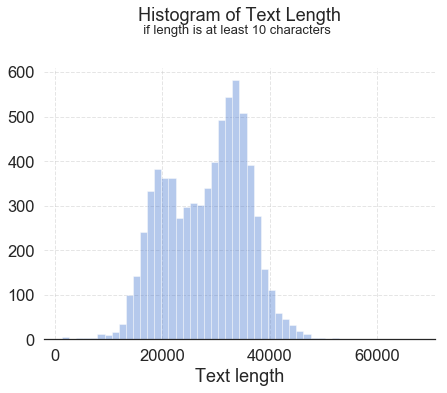

In [9]:
# test the data
df_data['text'] = df_data['text'].fillna('')
print('Number of texts with length < 10: ', len(df_data[df_data['text'].apply(len) < 10]))

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

df_data['Text length'] = df_data['text'].apply(len)

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(left=True)

# plot a simple histogram with binsize determined automatically
g = sns.distplot(df_data[df_data['Text length'] >= 10]['Text length'] , kde=False, color="b")

ax.grid(True, ls='--', alpha=0.5)
plt.title('Histogram of Text Length', y=1.15, fontsize=18)
plt.suptitle('  if length is at least 10 characters', y=1, fontsize=13)

In [10]:
print('Selected every 7th article for illustration')
df_data = df_data.iloc[::7]
len(df_data)

Selected every 7th article for illustration


1035

# Text preprocessing

In [11]:
# only lemmas of selected POS are considered for the modeling
# tuples of lemmas are formed from the selected sequences of lemmas in a sentence
# there is no tuple where one lemma is from on sentence and another from next sentence
# different numbers and pronouns in each text are replaced with NUM, PROPN
# if a lemma is followed by a adposition (in, for, during etc.) or PART ('s, not'),
# in a sentence it is included in the tuple

# delete missing values in text column and select only that column
df_data = df_data[df_data['text'].isnull() == False][['text']]

df_data = nlp.process_text(df_data, text_column='text')

		NLP getting list of sentences...
		NLP getting list of lemmas in each sentence...
		NLP selecting only lemmas with POSs = ['ADJ', 'NOUN', 'ADV', 'VERB']
		NLP creating modified lists of tuples (2-lemma phrases)...


In [12]:
# dataset structure
df_data.head(1).T

,0
text,TITLE\nSelf-Organization of Associative Databa...
lemmas,"title, efficient, method, self, organize, asso..."
2_lemma_phrases,"PROPN_of_PROPN, efficient_method_of, method_of..."
noun_phrases,"[TITLE, Self-Organization, Associative Databas..."


In [13]:
df_saved = df_data.copy()

Most frequent noun phrases:


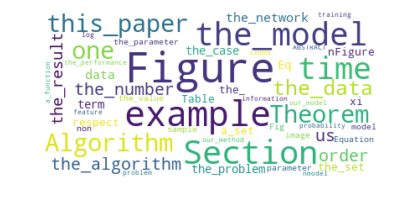

In [14]:
print("Most frequent noun phrases:")
df_data['noun_phrases'] = df_data['noun_phrases'].apply(str).str[2:-2]
df_data['noun_phrases'] = df_data['noun_phrases'].str.replace(" ", '_', regex=False)
df_data['noun_phrases'] = df_data['noun_phrases'].str.replace("',_'", ' ', regex=False)

text = ''
text = ' '.join(df_data['noun_phrases'].apply(str).str[1:-1].str.replace("'", '', regex=False))

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=50, 
                      background_color="white").generate(text)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Most frequent words:


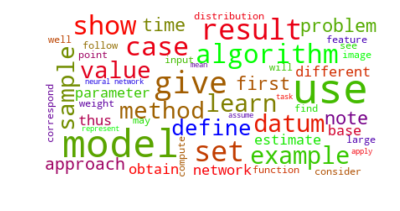

In [15]:
print("Most frequent words:")
text = ''
text = ' '.join(df_data['lemmas'])
text = text.replace(',', ' ')

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=50, 
                      colormap='brg_r',
                      background_color="white").generate(text)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Extract key-words/ key-phrases

### based on Tf-Idf scores

Key-words/key-phrases in a document are those with the highest Tf-Idf scores.

Hence, for a chosen document we need to sort the words/phrases in the vector in descending order of tf-idf values and then iterate over to extract the top-n items with the corresponding feature names,

In [16]:
# select column to extract key words/phrases
column = '2_lemma_phrases'

In [17]:
#instantiate CountVectorizer()
# delete corpus-specific stop words (words/phrases that have appear in more than 85% of documents) 
# max_df=0.95
# ignore terms that have a document frequency strictly lower than 1% of the documents 
# min_df=0.01

cv=CountVectorizer(max_df=0.95, min_df=0.01)

In [18]:
# generate word counts for the words in each text
count_vector=cv.fit_transform(df_data[column])

In [19]:
#compute the IDF values
# Smooth idf weights by adding one to document frequencies, 
# as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
# smooth_idf=True
# Enable inverse-document-frequency reweighting.
# use_idf=True

tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [20]:
# tf-idf scores
TfIdf_scores=tfidf_transformer.transform(count_vector)

In [21]:
# matrix size
print('There are ', TfIdf_scores.shape[0], 'documents in the corpus')
print('There are ', TfIdf_scores.shape[1], 'words/phrases extracted from each document in the corpus')

There are  1035 documents in the corpus
There are  16752 words/phrases extracted from each document in the corpus


In [22]:
#generate a data frame where 
# each column corresponds to a words/phrases in the corpus of documents
# each row corresponds to a document
# each cell has value of Tf-Idf score of the word/phrase from the corpus in the document

df_tf_idf = pd.DataFrame(TfIdf_scores.toarray(), columns=cv.get_feature_names())
df_tf_idf.head()

,a_a,a_b,a_be,a_c,a_can,a_have,a_n,a_num,a_p,a_priori,...,z_t,z_then,z_where,z_x,z_y,z_z,zero_element_of,zero_entry,zi_propn,zip_code
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.041989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
def print_key_words(doc_index, df_tf_idf, number_of_key_words=5):
    ts = df_tf_idf.iloc[doc_index]
    text = df_data['pring_text'].iloc[doc_index]
    
    print('============= Text =============')
    print(text)
    print('\nKey Words/Phrases with Tf-Idf Scores:\n')
    print(str(ts.sort_values(ascending=False)[:number_of_key_words])[:-23])

In [24]:
df_data['pring_text'] = df_data['text'].str.split('INTRODUCTION').str.get(0)

print_key_words(7, df_tf_idf, number_of_key_words=10)

============= Text =============
TITLE
Reinforcement Learning by Probability Matching.

ABSTRACT

We present a new algorithm for associative reinforcement learning. The algorithm is based upon the idea of matching a network's
output probability with a probability distribution derived from the
environment's reward signal. This Probability Matching algorithm
is shown to perform faster and be less susceptible to local minima
than previously existing algorithms. We use Probability Matching to train mixture of experts networks, an architecture for which
other reinforcement learning rules fail to converge reliably on even
simple problems. This architecture is particularly well suited for
our algorithm as it can compute arbitrarily complex functions yet
calculation of the output probability is simple.

1



Key Words/Phrases with Tf-Idf Scores:

output_distribution       0.325802
high_reward               0.260328
cost_function             0.196311
expert_be                 0.181001
num_exper